In [1]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
import os
%matplotlib inline

# object class in environment

In [2]:
class GameOb():
    def __init__(self, coordinates, size, intensity, channel, reward, name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

# grid world environment class

In [3]:
class GameEnv():
    def __init__(self, size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        a = self.reset()
        plt.imshow(a, interpolation="nearest")
        
    # reset    
    def reset(self):
        self.objects = []
        hero = GameOb(self.new_position(), 1, 1, 2, None, 'hero')
        self.objects.append(hero)
        goal = GameOb(self.new_position(), 1, 1, 1, 1, 'goal')
        self.objects.append(goal)
        hole = GameOb(self.new_position(), 1, 1, 0, -1, 'fire')
        self.objects.append(hole)
        goal2 = GameOb(self.new_position(), 1, 1, 1, 1, 'goal')
        self.objects.append(goal2)
        hole2 = GameOb(self.new_position(), 1, 1, 0, -1, 'fire')
        self.objects.append(hole2)
        goal3 = GameOb(self.new_position(), 1, 1, 1, 1, 'goal')
        self.objects.append(goal3)
        goal4 = GameOb(self.new_position(), 1, 1, 1, 1, 'goal')
        self.objects.append(goal4)
        state = self.render_env()
        self.state = state
        return state
    
    # move operation
    def move_char(self, direction):
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY-2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX-2:
            hero.x += 1
        self.objects[0] = hero
        
    # new position
    def new_position(self):
        iterables = [ range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        current_positions = []
        for objectA in self.objects:
            if (objectA.x, objectA.y) not in current_positions:
                current_positions.append((objectA.x, objectA.y))
        for pos in current_positions:
            points.remove(pos)
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]
    
    # check goal
    def check_goal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(GameOb(
                        self.new_position(), 1, 1, 1, 1, 'goal'))
                else:
                    self.objects.append(GameOb(
                        self.new_position(), 1, 1, 0, -1, 'fire'))
                return other.reward, False
        return 0.0, False
    
    # render environment
    def render_env(self):
        a = np.ones([self.sizeY+2, self.sizeX+2, 3])
        a[1:-1, 1:-1,:] = 0
        hero = None
        for item in self.objects:
            a[item.y+1:item.y+item.size+1, item.x+1:item.x+item.size+1,
                 item.channel] = item.intensity
        b = scipy.misc.imresize(a[:,:,0], [84,84,1], interp='nearest')
        c = scipy.misc.imresize(a[:,:,1], [84,84,1], interp='nearest')
        d = scipy.misc.imresize(a[:,:,2], [84,84,1], interp='nearest')
        a = np.stack([b,c,d], axis=2)
        return a
    
    # action and check
    def step(self, action):
        self.move_char(action)
        reward, done = self.check_goal()
        state = self.render_env()
        return state, reward, done

# deep q-network class

In [4]:
class Qnetwork():
    def __init__(self, h_size):
        self.scalar_input = tf.placeholder(shape=[None, 21168], dtype=tf.float32)
        self.image_in = tf.reshape(self.scalar_input, shape=[-1,84,84,3])
        self.conv1 = tf.contrib.layers.convolution2d(
            inputs=self.image_in, num_outputs=32,
            kernel_size=[8,8], stride=[4,4],
            padding='valid', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d(
            inputs=self.conv1, num_outputs=64,
            kernel_size=[4,4], stride=[2,2],
            padding='valid', biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d(
            inputs=self.conv2, num_outputs=64,
            kernel_size=[3,3], stride=[1,1],
            padding='valid', biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d(
            inputs=self.conv3, num_outputs=512,
            kernel_size=[7,7], stride=[1,1],
            padding='valid', biases_initializer=None)
        
        # split q funtion to static (value) and dynamic (action) parts
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        self.aw = tf.Variable(tf.random_normal([h_size//2, env.actions]))
        self.vw = tf.Variable(tf.random_normal([h_size//2, 1]))
        self.advantage = tf.matmul(self.streamA, self.aw)
        self.value = tf.matmul(self.streamV, self.vw)
        
        # merge value and advantage
        self.q_out = self.value + tf.subtract(self.advantage, 
            tf.reduce_mean(self.advantage, reduction_indices=1, keep_dims=True))
        self.predict = tf.argmax(self.q_out, 1)
        
        # placeholder and calculate q
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32)
        self.q = tf.reduce_sum(tf.multiply(self.q_out, self.actions_onehot),
                              reduction_indices=1)
        
        # define loss
        self.td_error = tf.square(self.targetQ - self.q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.update_model = self.trainer.minimize(self.loss)

# experience replay class

In [5]:
class experience_buffer():
    def __init__(self, buffer_size=50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])

# flat states function

In [6]:
def process_state(states):
    return np.reshape(states, [21168])

# update target dqn-network model

In [7]:
def update_target_graph(tf_vars, tau):
    total_vars = len(tf_vars)
    op_holder = []
    for idx, var in enumerate(tf_vars[0:total_vars//2]):
        op_holder.append(tf_vars[idx+total_vars//2].assign((var.value() * tau) + \
                ((1-tau) * tf_vars[idx+total_vars//2].value())))
    return op_holder

def update_target(op_holder, sess):
    for op in op_holder:
        sess.run(op)

# grid world environment instance

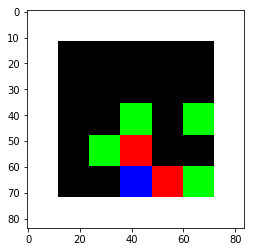

In [8]:
env = GameEnv(size=5)

# dqn-network and train parameters

In [9]:
# sample size from experience buffer
batch_size = 32
# model parameters update freq
update_freq = 4
# q discount factor
y = .99
# random action probability in the beginning
startE = 1
endE = 0.1
# steps from primary random prob to final random prob
anneling_steps = 10000.
# nums of grid world env experiment
num_episodes = 10000
# dqn random action test
pre_train_steps = 10000
# action steps per episode
max_ep_length = 50
load_model = False
# model save path
path = "./dqn"
# final fully-connected layer hidden nodes
h_size = 512
# learning rate from target dqn to main dqn
tau = 0.001

# init mainQN and targetQN

In [10]:
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)
init = tf.global_variables_initializer()

# train parameters
trainables = tf.trainable_variables()
target_ops = update_target_graph(trainables, tau)

my_buffer = experience_buffer()
e = startE
step_drop = (startE - endE) / anneling_steps

r_list = []
total_steps = 0

saver = tf.train.Saver()
if not os.path.exists(path):
    os.makedirs(path)

# sess, experience buffer save, avg reward and model save

In [11]:
with tf.Session() as sess:
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    sess.run(init)
    update_target(target_ops, sess)
    for i in range(num_episodes+1):
        episode_buffer = experience_buffer()
        s = env.reset()
        s = process_state(s)
        # done
        d = False
        # reward in episode
        r_all = 0
        # steps in episode
        j = 0
        
        while j < max_ep_length:
            j += 1
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0, 4)
            else:
                a = sess.run(mainQN.predict, feed_dict={mainQN.scalar_input:[s]})[0]
            s1, r, d = env.step(a)
            s1 = process_state(s1)
            total_steps += 1
            episode_buffer.add(np.reshape(np.array([s,a,r,s1,d]), [1,5]))
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= step_drop
                if total_steps % (update_freq) == 0:
                    train_batch = my_buffer.sample(batch_size)
                    # input next state into mainQN and predict
                    a = sess.run(mainQN.predict, feed_dict={
                        mainQN.scalar_input: np.vstack(train_batch[:,3])})
                    # then input next state into targetQN and get q
                    q = sess.run(targetQN.q_out, feed_dict={
                        targetQN.scalar_input: np.vstack(train_batch[:,3])})
                    doubleQ = q[range(batch_size), a]
                    # reward + doubleQ * discount
                    targetQ = train_batch[:,2] + y*doubleQ
                    _ = sess.run(mainQN.update_model, feed_dict={
                        mainQN.scalar_input: np.vstack(train_batch[:,0]),
                        mainQN.targetQ: targetQ,
                        mainQN.actions: train_batch[:,1]})
                    
                    update_target(target_ops, sess)
            r_all += r
            s = s1
            
            if d == True:
                break
        
        # model save
        my_buffer.add(episode_buffer.buffer)
        r_list.append(r_all)
        if i>0 and i%25 == 0:
            print('episode', i, ', average reward of last 25 episode', 
                  np.mean(r_list[-25:]))
        if i>0 and i%1000 == 0:
            saver.save(sess, path+'/model-'+str(i)+'.ckpt')
            print("Saved Model!")
    saver.save(sess, path+'/model-'+str(i)+'.ckpt')

('episode', 25, ', average reward of last 25 episode', 1.8799999999999999)
('episode', 50, ', average reward of last 25 episode', 1.24)
('episode', 75, ', average reward of last 25 episode', 1.6399999999999999)
('episode', 100, ', average reward of last 25 episode', 1.2)
('episode', 125, ', average reward of last 25 episode', 2.3199999999999998)
('episode', 150, ', average reward of last 25 episode', 2.1200000000000001)
('episode', 175, ', average reward of last 25 episode', 2.3999999999999999)
('episode', 200, ', average reward of last 25 episode', 2.2799999999999998)
('episode', 225, ', average reward of last 25 episode', 2.1200000000000001)
('episode', 250, ', average reward of last 25 episode', 2.0)
('episode', 275, ', average reward of last 25 episode', 1.8)
('episode', 300, ', average reward of last 25 episode', 0.80000000000000004)
('episode', 325, ', average reward of last 25 episode', 0.88)
('episode', 350, ', average reward of last 25 episode', 1.3600000000000001)
('episode',

('episode', 2900, ', average reward of last 25 episode', 19.68)
('episode', 2925, ', average reward of last 25 episode', 19.640000000000001)
('episode', 2950, ', average reward of last 25 episode', 18.920000000000002)
('episode', 2975, ', average reward of last 25 episode', 19.760000000000002)
('episode', 3000, ', average reward of last 25 episode', 20.52)
Saved Model!
('episode', 3025, ', average reward of last 25 episode', 20.68)
('episode', 3050, ', average reward of last 25 episode', 21.32)
('episode', 3075, ', average reward of last 25 episode', 20.559999999999999)
('episode', 3100, ', average reward of last 25 episode', 20.440000000000001)
('episode', 3125, ', average reward of last 25 episode', 20.399999999999999)
('episode', 3150, ', average reward of last 25 episode', 21.120000000000001)
('episode', 3175, ', average reward of last 25 episode', 21.199999999999999)
('episode', 3200, ', average reward of last 25 episode', 20.16)
('episode', 3225, ', average reward of last 25 epis

('episode', 5675, ', average reward of last 25 episode', 21.960000000000001)
('episode', 5700, ', average reward of last 25 episode', 23.239999999999998)
('episode', 5725, ', average reward of last 25 episode', 21.640000000000001)
('episode', 5750, ', average reward of last 25 episode', 22.039999999999999)
('episode', 5775, ', average reward of last 25 episode', 23.0)
('episode', 5800, ', average reward of last 25 episode', 21.760000000000002)
('episode', 5825, ', average reward of last 25 episode', 19.879999999999999)
('episode', 5850, ', average reward of last 25 episode', 22.48)
('episode', 5875, ', average reward of last 25 episode', 23.079999999999998)
('episode', 5900, ', average reward of last 25 episode', 21.600000000000001)
('episode', 5925, ', average reward of last 25 episode', 22.52)
('episode', 5950, ', average reward of last 25 episode', 22.960000000000001)
('episode', 5975, ', average reward of last 25 episode', 21.359999999999999)
('episode', 6000, ', average reward of 

('episode', 8425, ', average reward of last 25 episode', 22.359999999999999)
('episode', 8450, ', average reward of last 25 episode', 23.079999999999998)
('episode', 8475, ', average reward of last 25 episode', 22.84)
('episode', 8500, ', average reward of last 25 episode', 22.32)
('episode', 8525, ', average reward of last 25 episode', 22.0)
('episode', 8550, ', average reward of last 25 episode', 23.359999999999999)
('episode', 8575, ', average reward of last 25 episode', 23.48)
('episode', 8600, ', average reward of last 25 episode', 23.800000000000001)
('episode', 8625, ', average reward of last 25 episode', 23.16)
('episode', 8650, ', average reward of last 25 episode', 22.16)
('episode', 8675, ', average reward of last 25 episode', 23.800000000000001)
('episode', 8700, ', average reward of last 25 episode', 22.879999999999999)
('episode', 8725, ', average reward of last 25 episode', 22.359999999999999)
('episode', 8750, ', average reward of last 25 episode', 22.199999999999999)
(

# plt reward

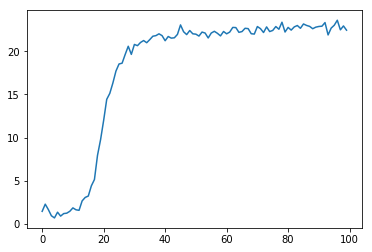

In [12]:
r_mat = np.resize(np.array(r_list),  [len(r_list)//100, 100])
r_mean = np.average(r_mat, 1)
plt.plot(r_mean)